In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2
%load_ext snakeviz


import random

import geopandas as gpd
import numpy as np
import pandas as pd
import verde as vd
import xarray as xr

# make beep sound when notify is called at end of long-running cells
from IPython.display import Audio
from polartoolkit import fetch, maps, utils

wave = np.sin(2 * np.pi * 400 * np.arange(10000 * 1) / 10000)
notify = Audio(wave, rate=10000, autoplay=True)

In [2]:
# choose resolution

layer_spacing = 5e3
# layer_spacing = 10e3

grav_spacing = 5e3
# grav_spacing = 10e3

# Load inversion inputs

In [ ]:
# weights grid and starting bathymetry
starting_prisms = xr.open_zarr(
    f"../inversion_layers/RIS_starting_prisms_{int(layer_spacing)}k_constraints.zarr"
)

# gravity data and anomalies
grav = pd.read_csv(
    "../data/RIS_bouguer_corrections_50k_filt_mask.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# set regions
buffer_region = utils.get_grid_info(starting_prisms.density)[1]
inversion_region = vd.get_region((grav.easting, grav.northing))

# set layer parameters
registration = utils.get_grid_info(starting_prisms.density)[4]

print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

# constraints
if layer_spacing == 5e3:
    constraints_fname = "../data/bed_constraints_5k.csv.gz"
elif layer_spacing == 10e3:
    constraints_fname = "../data/bed_constraints_10k.csv.gz"
else:
    raise ValueError("No constraint point files available at specified spacing!")

constraints = pd.read_csv(
    constraints_fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# mark points inside grounding line as "inside"
measures_shelves = fetch.measures_boundaries(version="IceShelf")
ice_shelves = gpd.read_file(measures_shelves)
RIS_seperate = ice_shelves[ice_shelves.NAME.isin(["Ross_West", "Ross_East"])]
RIS = RIS_seperate.dissolve()
gdf = gpd.GeoDataFrame(
    constraints,
    geometry=gpd.points_from_xy(x=constraints.easting, y=constraints.northing),
    crs="EPSG:3031",
)
constraints["inside"] = gdf.within(RIS.geometry[0])
constraints = constraints.drop(columns="geometry")

# ensure all points are within buffer region
constraints = utils.points_inside_region(
    constraints, buffer_region, names=("easting", "northing")
)
print(f"bathymetry control points:{len(constraints)}")

# starting bed
if layer_spacing == 5e3:
    fname = "../inversion_layers/bed_from_constraints_5k.zarr"
elif layer_spacing == 10e3:
    fname = "../inversion_layers/bed_from_constraints_10k.zarr"
else:
    raise ValueError("No bed grids available at specified spacing!")
bed_full = xr.open_zarr(fname).bed
bed = fetch.resample_grid(
    bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)

# icebase
fname = "../inversion_layers/bedmachine_icebase.zarr"
icebase_full = xr.open_zarr(fname).icebase
icebase_layer_spacing = fetch.resample_grid(
    icebase_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)

# final inverted bathymetry model
fname = "../results/weights_mask_prism_results.csv.gz"
inverted_bathy = pd.read_csv(
    fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
inverted_bathy = inverted_bathy.set_index(["northing", "easting"]).to_xarray()[
    inverted_bathy.columns[-1]
]

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


layer spacing: 5000.0m
registration: g
inversion region =  (-580000.0, 385000.0, -1385000.0, -445000.0)
buffer region =  [-620000.0, 460000.0, -1460000.0, -380000.0]
bathymetry control points:28087
spacing larger than original, filtering and resampling


# Bootstrap uncertainty analysis with gravity data
* Divide the gravity data into 100x100km bins
* Run an inversion for each bin, with the bin's data excluded
* collect all resulting bathymetry models
* find standard deviation of each pixel from the range of models
Ex. for 100 bins, run the inversion 100 times, each time using 99 bins of data. 

## Split gravity data into `Training` and `Testing`

In [4]:
block_spacing = 100e3
# block_spacing = 500e3
block_centers, labels = vd.block_split(
    (grav.easting, grav.northing),
    spacing=block_spacing,
    # shape = (5,5),
)
grav["block_label"] = labels

print(f"{len(grav.block_label.unique())} blocks")

grav

71 blocks


,northing,easting,Gobs,upward,surface_forward,icebase_forward,Gobs_corr,bed_forward,block_label
0,-1385000.0,55000.0,-5.917760,1000.0,-20.684952,0.044324,14.722868,-18.890848,6
1,-1385000.0,60000.0,-3.988423,1000.0,-20.665307,0.046457,16.630428,-18.311723,6
2,-1380000.0,45000.0,-10.974624,1000.0,-20.701629,0.042514,9.684491,-21.866672,6
3,-1380000.0,50000.0,-7.966111,1000.0,-20.691564,0.043529,12.681924,-21.290713,6
4,-1380000.0,55000.0,-5.154862,1000.0,-20.669303,0.045952,15.468489,-20.048731,6
...,...,...,...,...,...,...,...,...,...
22236,-445000.0,-210000.0,-26.054879,1000.0,-15.087119,0.030805,-10.998566,10.640792,83
22237,-445000.0,-205000.0,-25.186605,1000.0,-11.738032,0.551109,-13.999682,16.649674,83
22238,-445000.0,-200000.0,-22.535298,1000.0,-1.044918,2.062803,-23.553182,32.654473,83
22239,-445000.0,-195000.0,-18.995592,1000.0,-3.329588,1.836528,-17.502531,32.284136,83


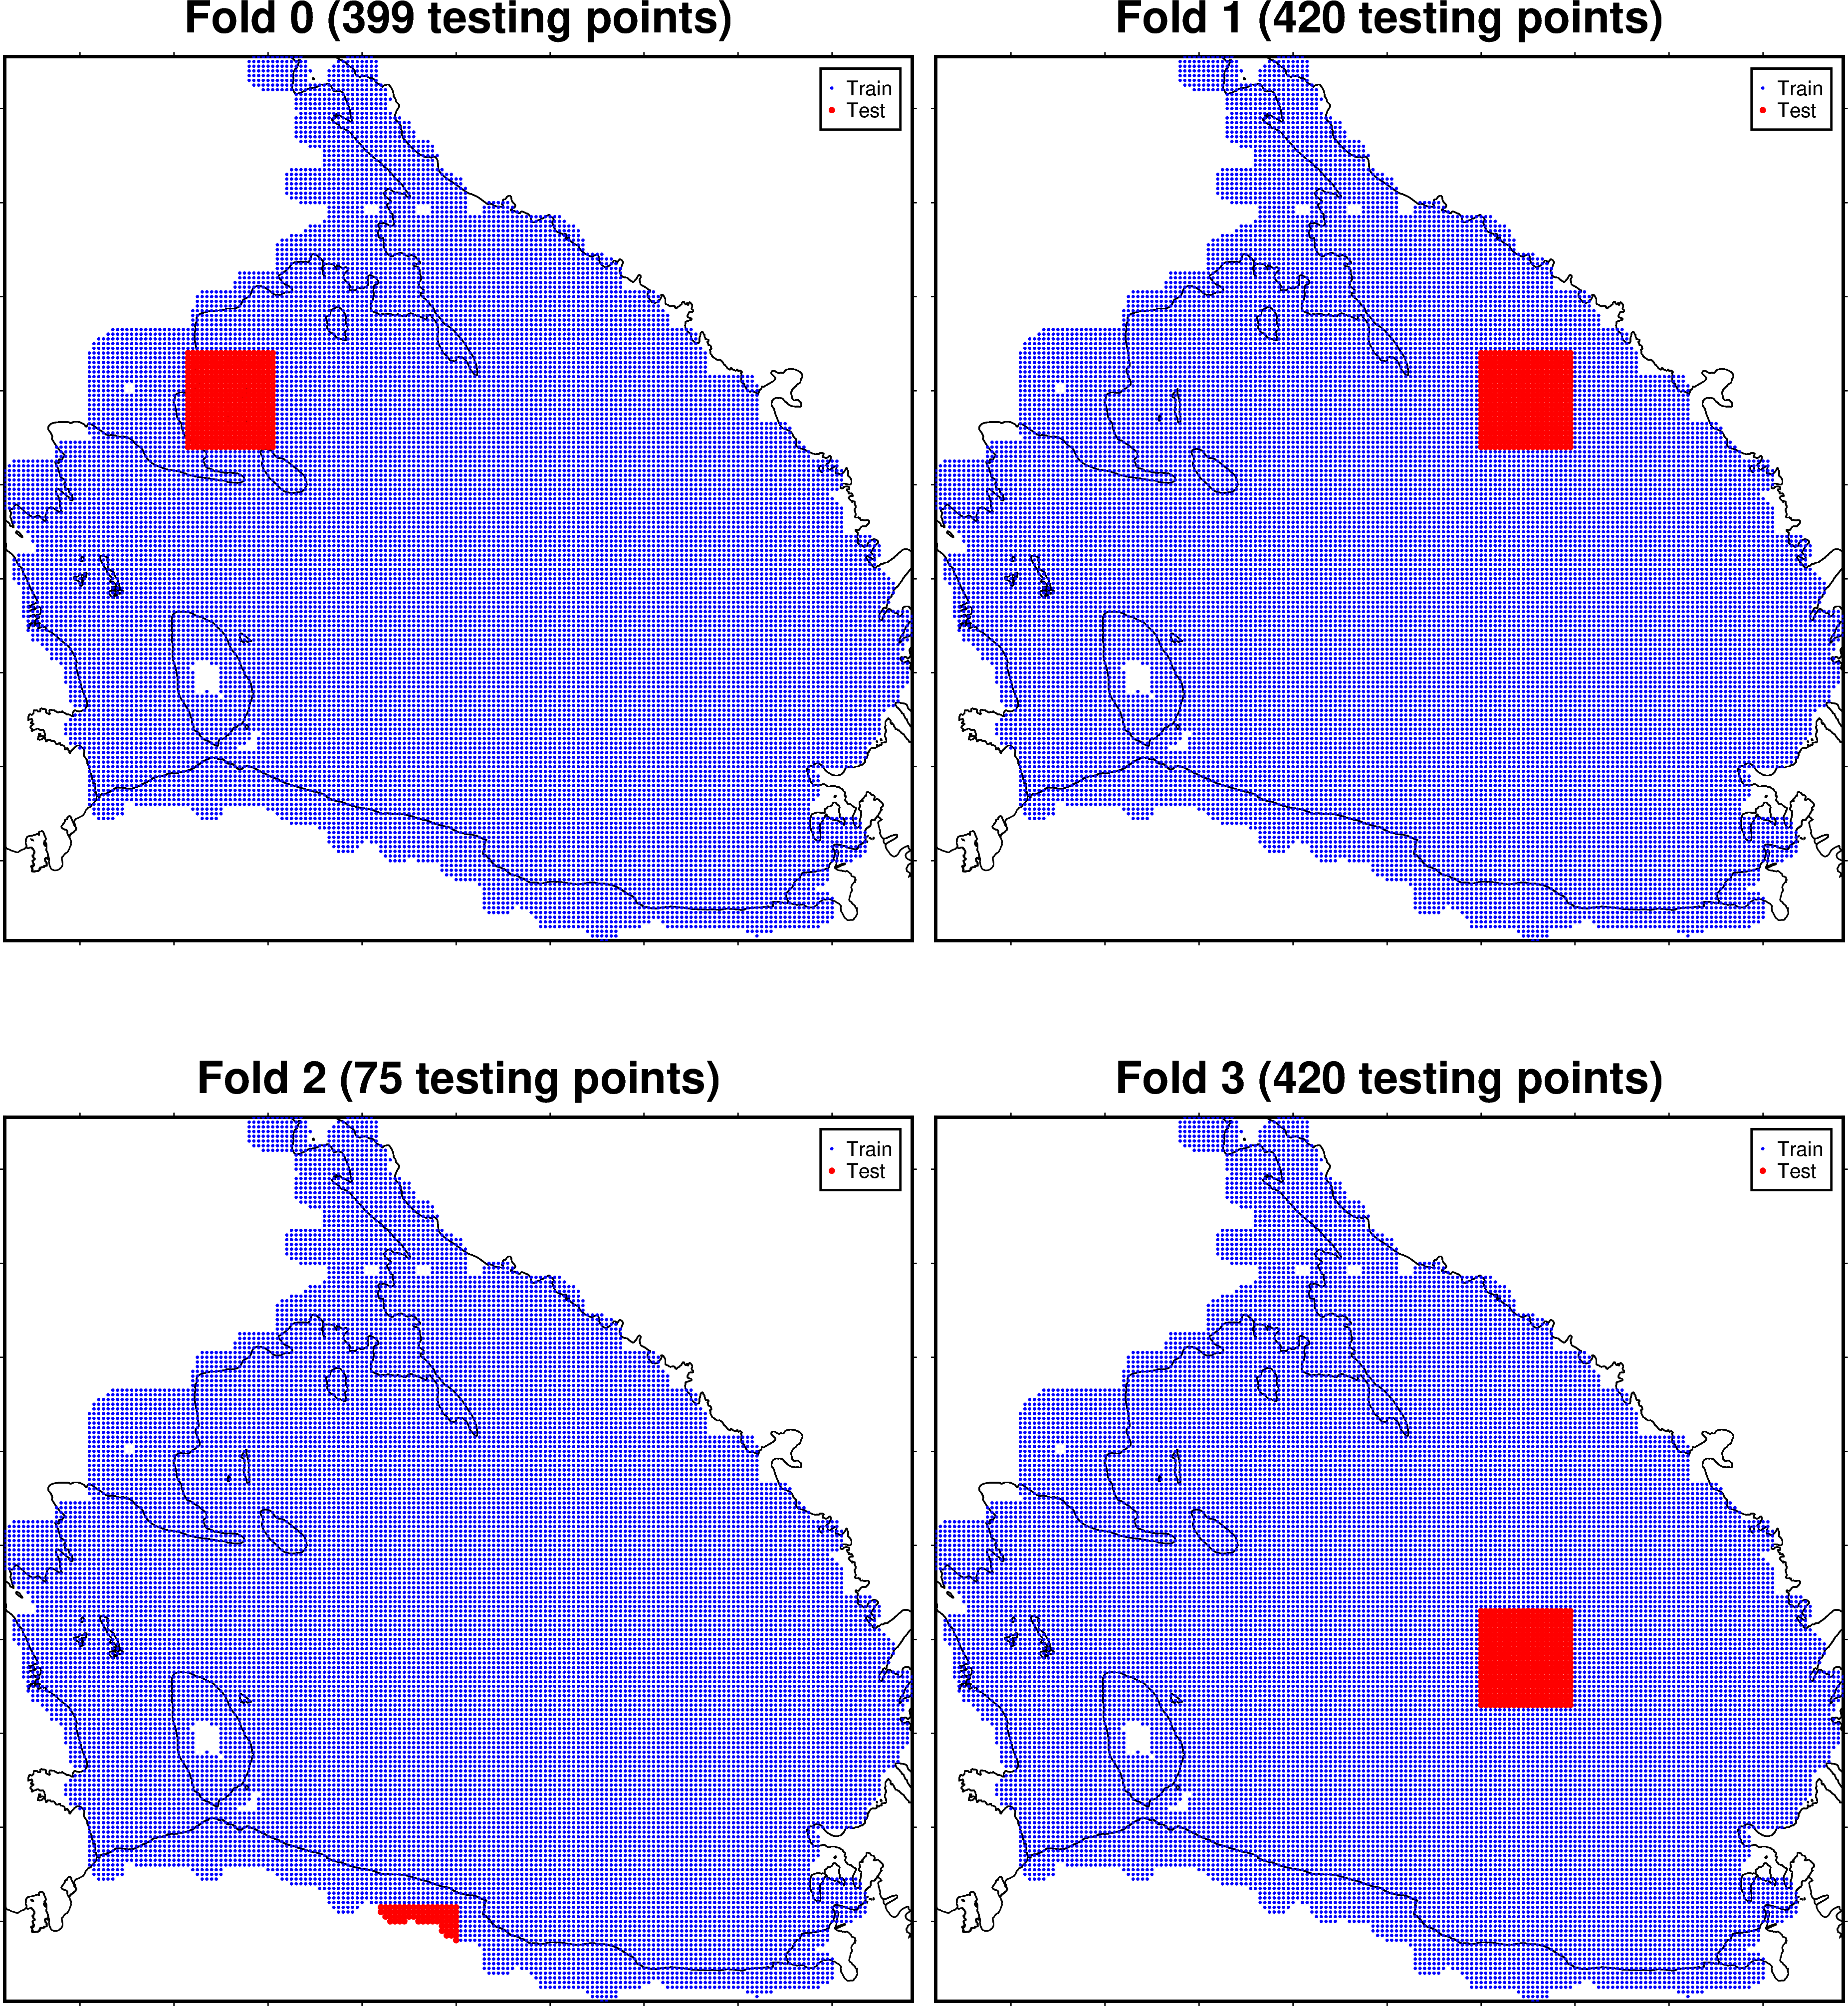

In [5]:
number_to_plot = 4

df = grav.copy()
blocks = list(df.block_label.unique())

if number_to_plot is not None:
    random.seed(0)
    blocks = random.sample(blocks, number_to_plot)

_, ncols = utils.square_subplots(len(blocks))

for i, b in enumerate(blocks):
    if i == 0:
        fig = (None,)
        origin_shift = "initialize"
        xshift_amount = None
        yshift_amount = None
    elif i % ncols == 0:
        fig = fig
        origin_shift = "both_shift"
        xshift_amount = -ncols + 1
        yshift_amount = -1
    else:
        fig = fig
        origin_shift = "xshift"
        xshift_amount = 1
        yshift_amount = 1

    df_test = df[df.block_label == b]
    df_train = df[df.block_label != b]

    fig = maps.basemap(
        region=vd.get_region((df.easting, df.northing)),
        title=f"Fold {i} ({len(df_test)} testing points)",
        coast=True,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=yshift_amount,
        fig=fig,
    )

    fig.plot(
        x=df_train.easting,
        y=df_train.northing,
        style="c.05c",
        fill="blue",
        label="Train",
    )
    fig.plot(
        x=df_test.easting,
        y=df_test.northing,
        style="c.1c",
        fill="red",
        label="Test",
    )

    fig.legend()
fig.show()

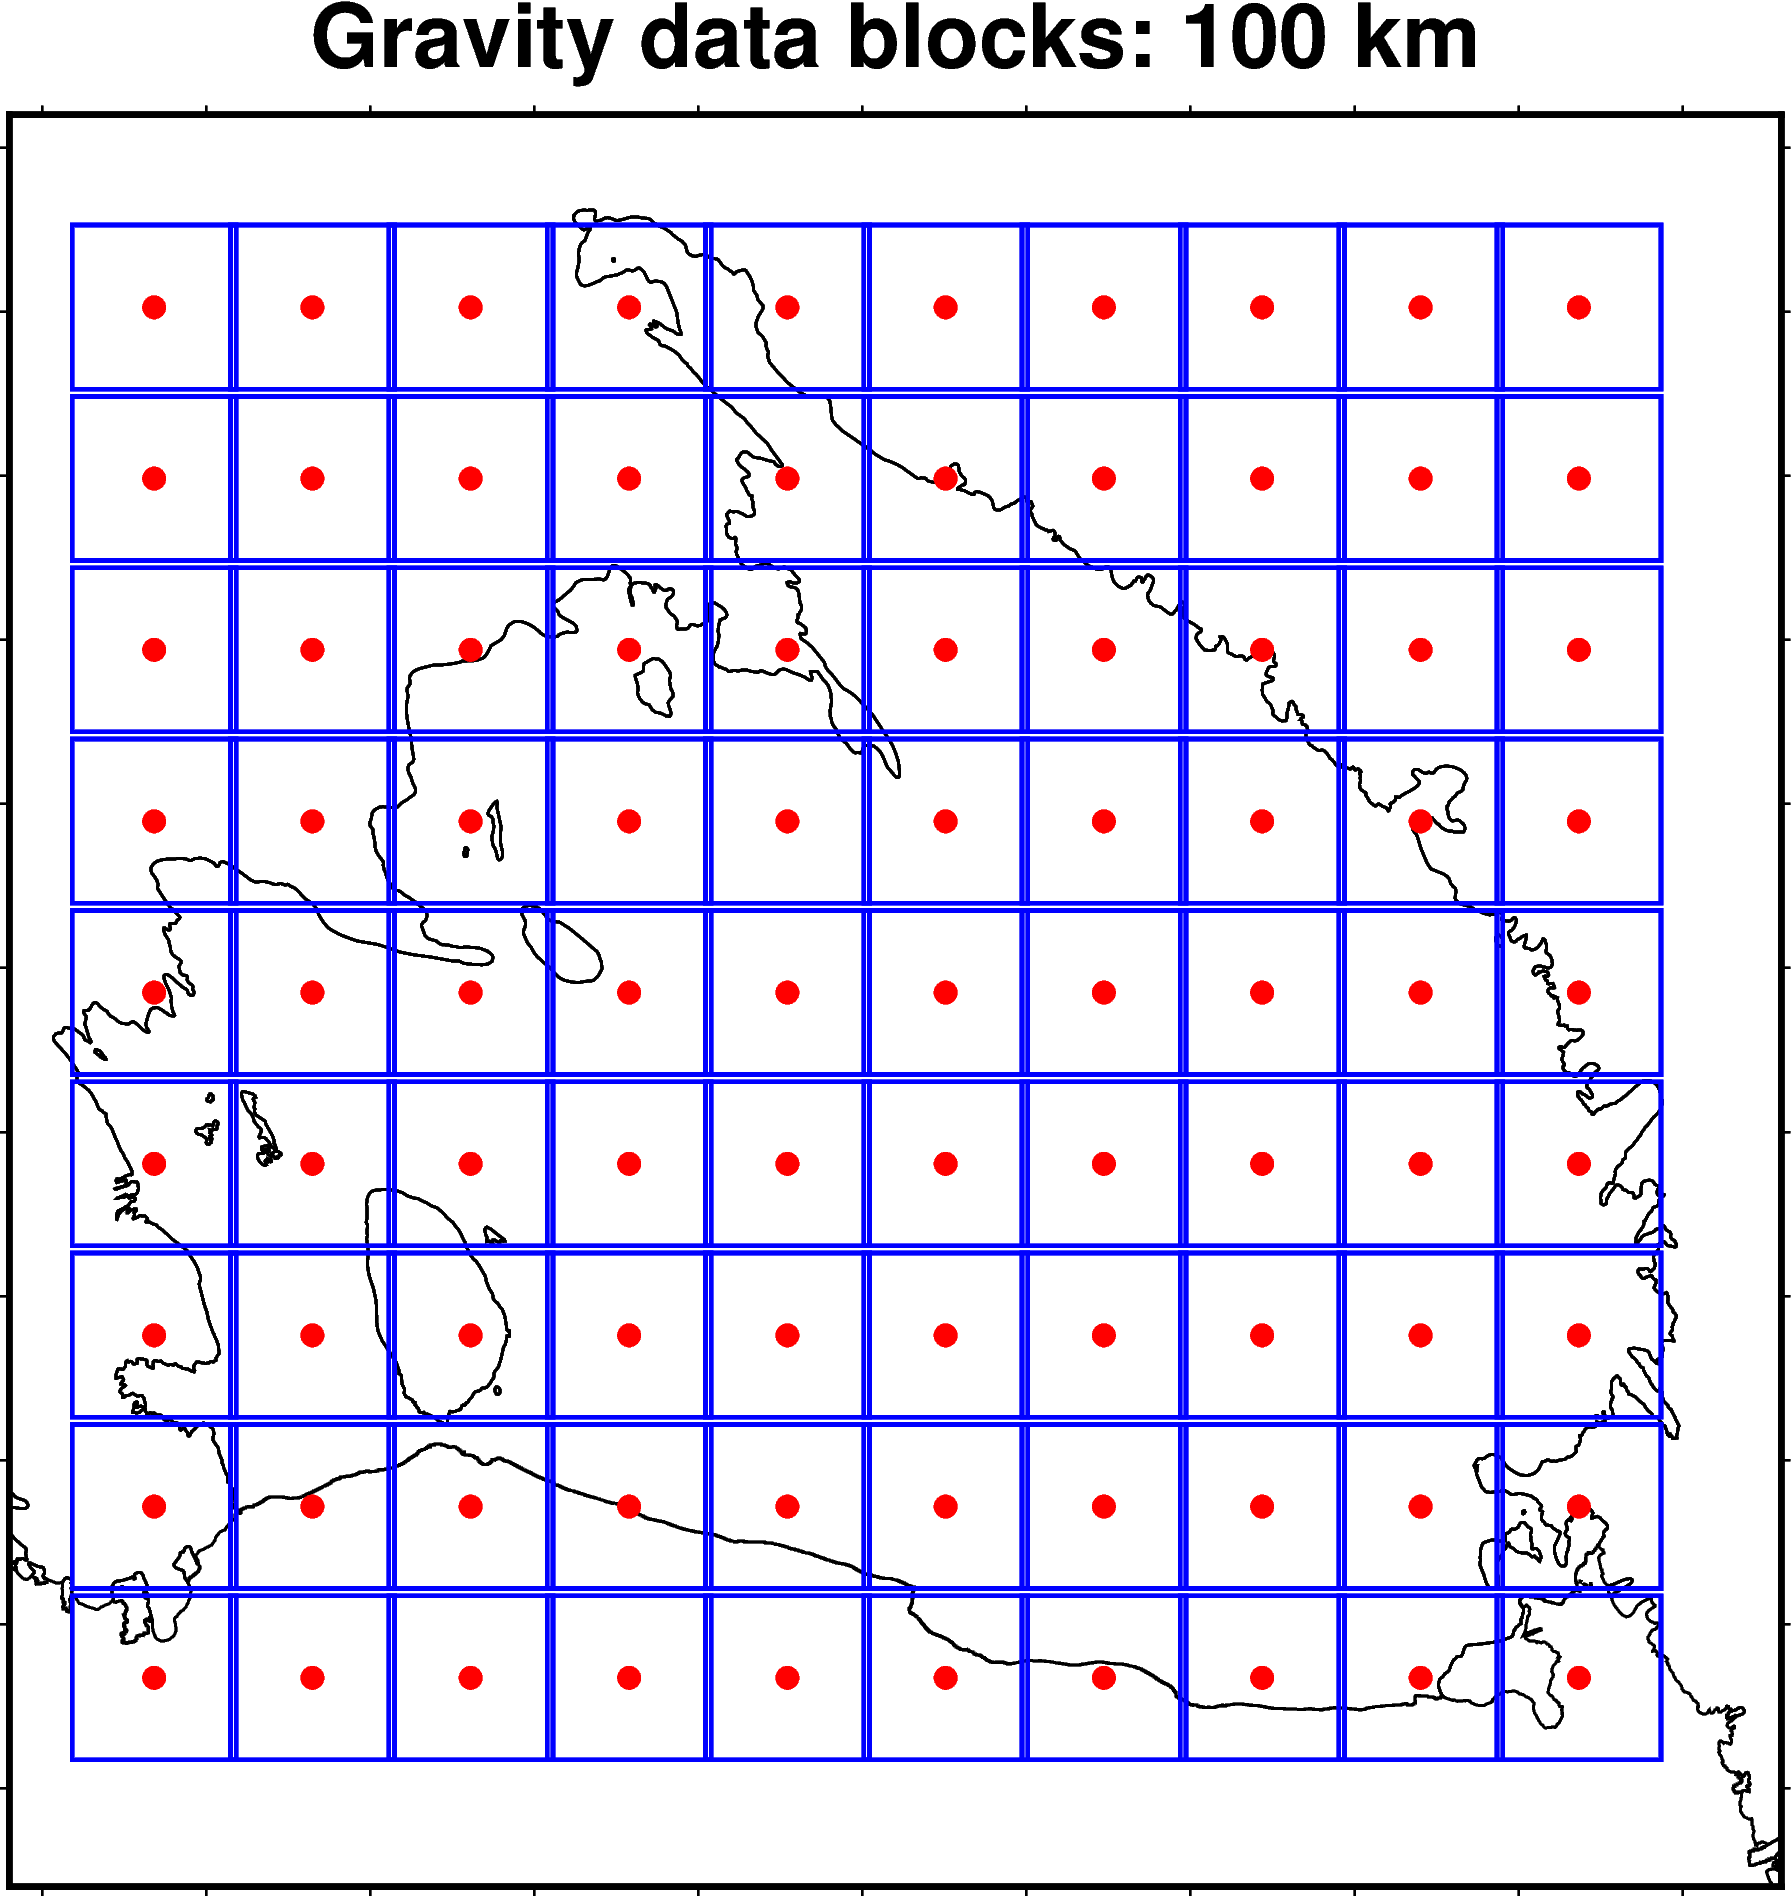

In [6]:
# plot block centers and boxes
fig = maps.basemap(
    region=buffer_region,
    coast=True,
    title=f"Gravity data blocks: {int(block_spacing/1e3)} km",
)

fig.plot(
    x=block_centers[0],
    y=block_centers[1],
    style="c0.2c",
    fill="red",
)

for x, y in zip(block_centers[0], block_centers[1]):
    region = [
        x - block_spacing / 2,
        x + block_spacing / 2,
        y - block_spacing / 2,
        y + block_spacing / 2,
    ]
    maps.add_box(fig, region, pen="1p,blue")

fig.show()

# Run boot-strapping with gravity data

In [5]:
anomaly_args = {
    "input_forward_column": "bed_forward",
    "input_grav_column": "Gobs_corr",
    "regional_method": "constraints",
    "constraints": constraints,
    "grav_spacing": grav_spacing,
    "inversion_region": inversion_region,
    "tension_factor": 0.25,
}

inversion_args = {
    "prism_layer": starting_prisms,
    "input_grav_column": "Gobs_corr_shift",
    "apply_weights": True,
    "max_iterations": 10,
    "l2_norm_tolerance": 0.2,
    "delta_l2_norm_tolerance": 0.8,
    "perc_increase_limit": 0.2,
    "upper_confining_layer": icebase_layer_spacing,
    "deriv_type": "annulus",
    "solver_type": "scipy least squares",
    "solver_damping": 0.1,
}

# get list of blocks
blocks = list(grav.block_label.unique())

# for each block, remove the gravity data within, calculate the regional/residual misfits,
# run inversion on remaining data and
# return the final topography

# for i, b in enumerate(blocks):
#     topo = inv_utils.inversion_gravity_cross_val_score(
#         grav[grav.block_label!=b],
#         anomaly_args,
#         inversion_args,
#         calculate_anomalies = True,
#     ).to_dataset(name=f"block_{b}")

#     if i == 0:
#         mode = "w"
#     else:
#         mode = "a"

#     enc = {x: {"compressor": zarr.Blosc()} for x in topo}
#     topo.to_zarr(
#         "../data/CV_gravity_topos_incl_regional.zarr",
#         encoding=enc,
#         mode=mode,
#     )
#     print(f"Finished inversion {i+1} of {len(blocks)}")

In [6]:
# load dataset with all the topo models
topos = xr.open_zarr("../data/CV_gravity_topos_incl_regional.zarr")

# merge variables into a single variable with a new axis "folds"
variables = list(topos)
ds_merged = (
    xr.concat([topos[var] for var in variables], dim="folds")
    .assign_coords({"folds": variables})
    .rename("fold_num")
    .to_dataset()
)
ds_merged

<xarray.Dataset>
Dimensions:   (easting: 217, northing: 217, folds: 71)
Coordinates:
  * easting   (easting) float64 -6.2e+05 -6.15e+05 -6.1e+05 ... 4.55e+05 4.6e+05
  * northing  (northing) float64 -1.46e+06 -1.455e+06 ... -3.85e+05 -3.8e+05
  * folds     (folds) <U8 'block_10' 'block_11' ... 'block_84' 'block_9'
Data variables:
    fold_num  (folds, northing, easting) float64 dask.array<chunksize=(1, 109, 217), meta=np.ndarray>

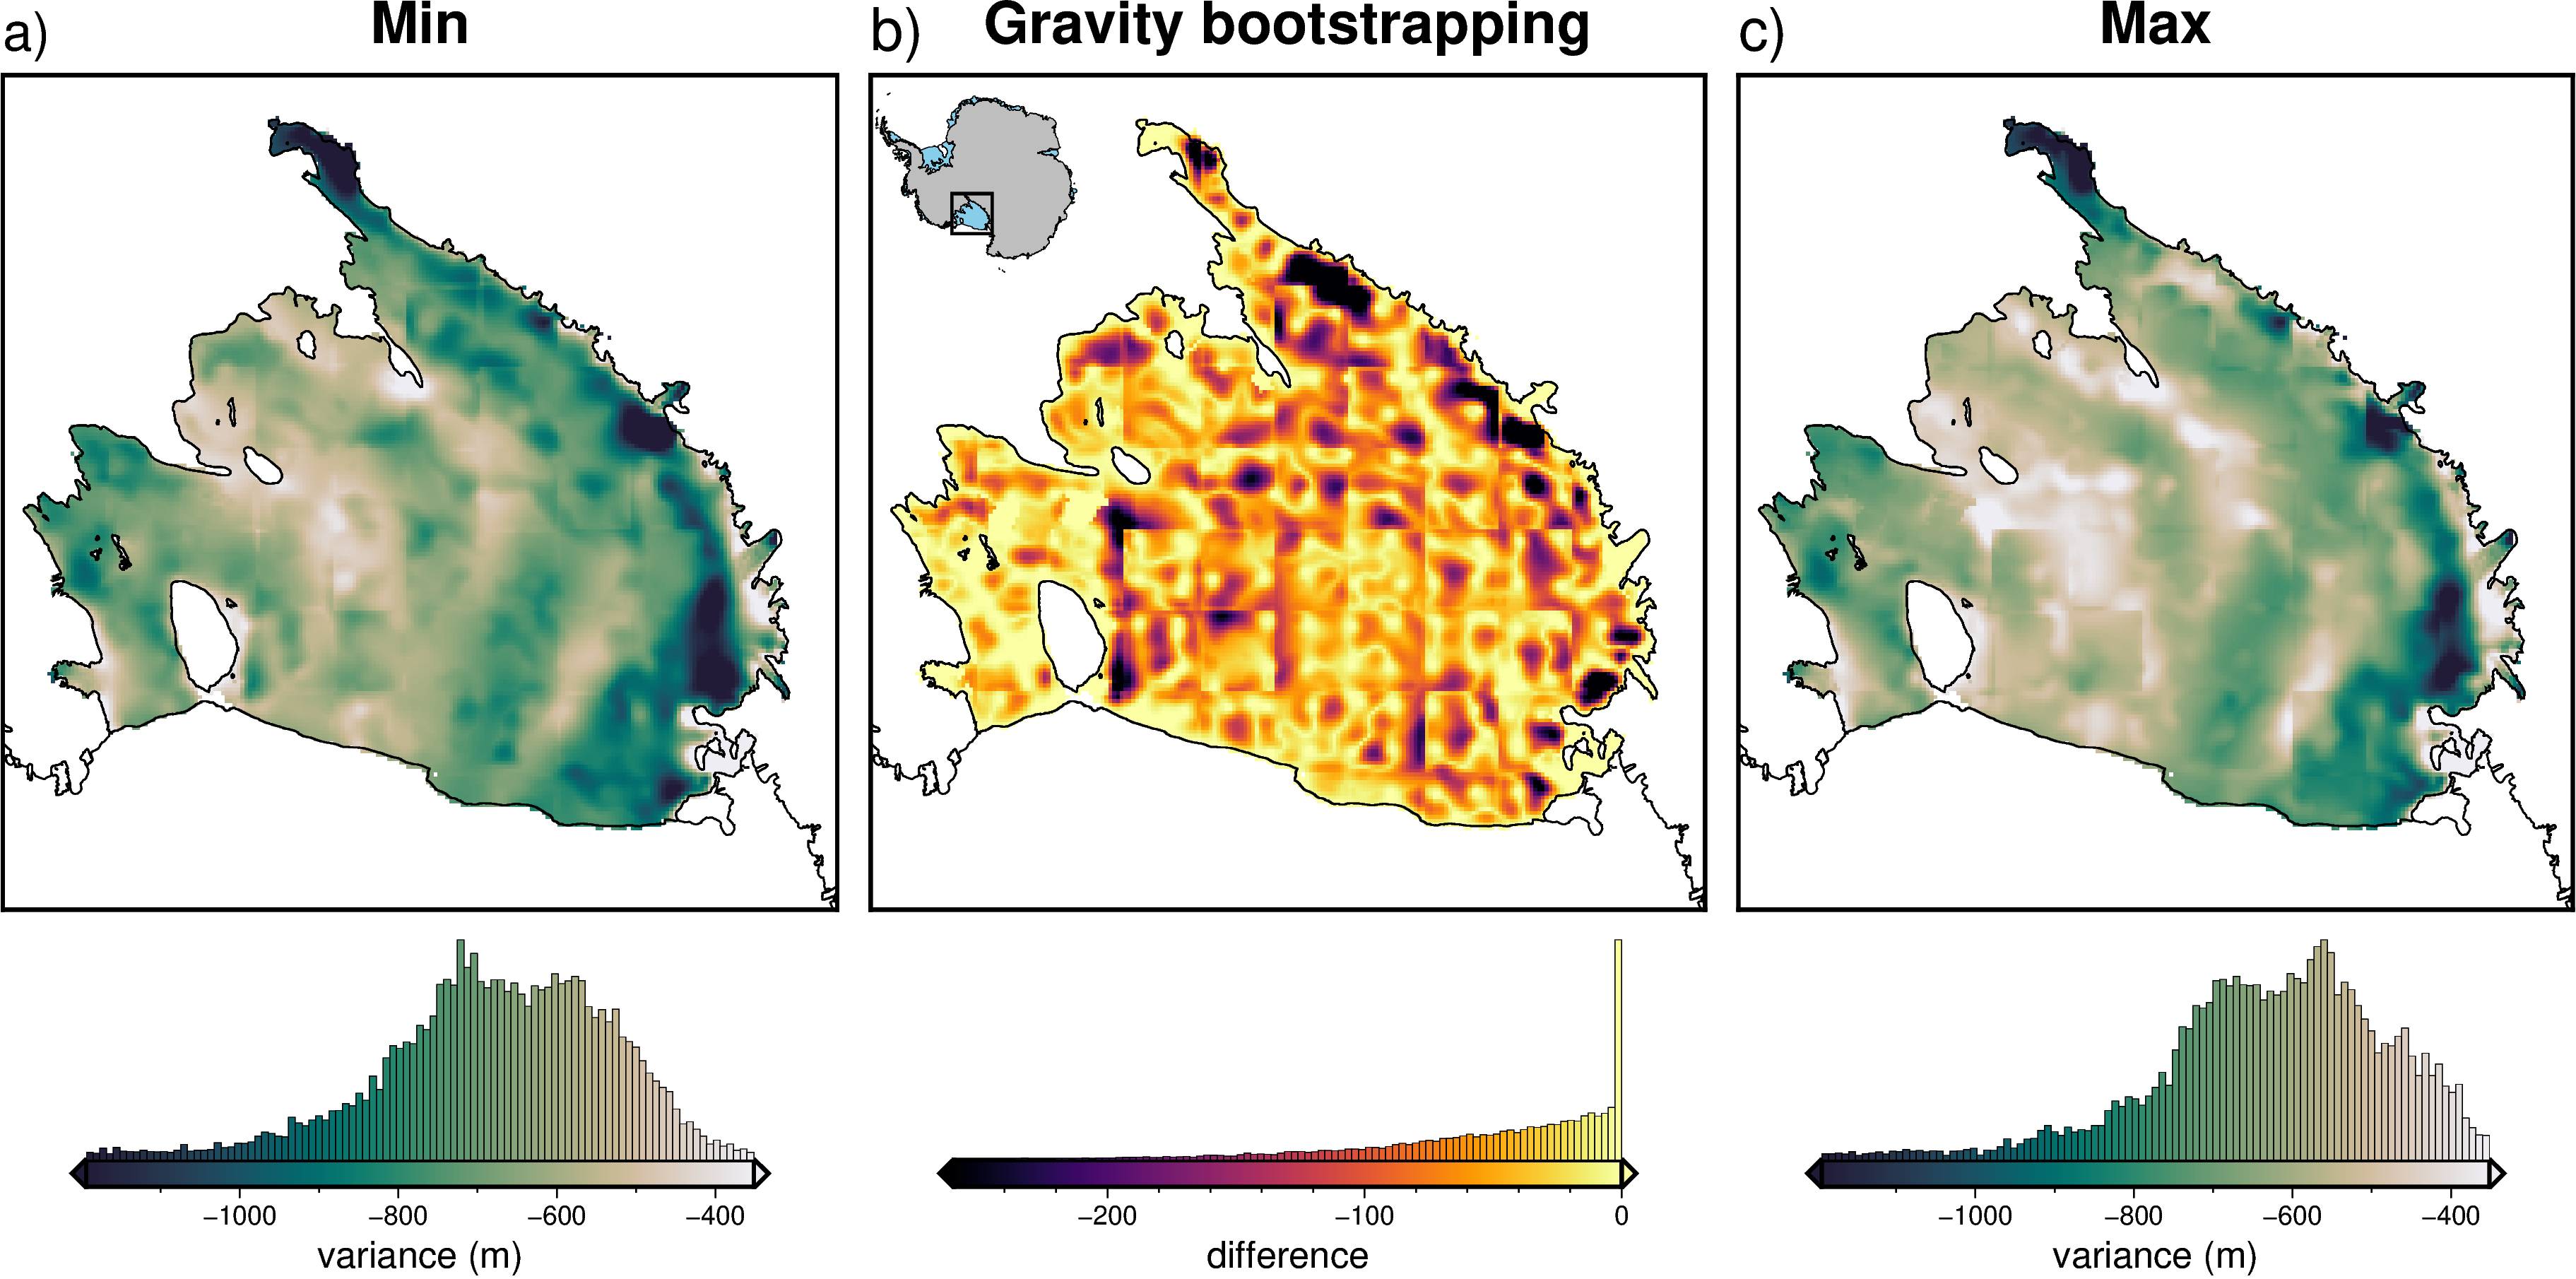

In [7]:
merged_min = ds_merged["fold_num"].min("folds")
merged_max = ds_merged["fold_num"].max("folds")
merged_min = utils.mask_from_shp(
    shapefile="../plotting/RIS_outline.shp",
    xr_grid=merged_min,
    masked=True,
    invert=False,
)
merged_max = utils.mask_from_shp(
    shapefile="../plotting/RIS_outline.shp",
    xr_grid=merged_max,
    masked=True,
    invert=False,
)

_ = utils.grd_compare(
    merged_min,
    merged_max,
    plot=True,
    grid1_name="Min",
    grid2_name="Max",
    title="Gravity bootstrapping",
    cbar_label="variance (m)",
    diff_cmap="inferno",
    diff_maxabs=False,
    cmap="rain",
    reverse_cpt=True,
    rmse_in_title=False,
    subplot_labels=True,
    robust=True,
    hist=True,
    # shp_mask="../plotting/RIS_outline.shp",
)

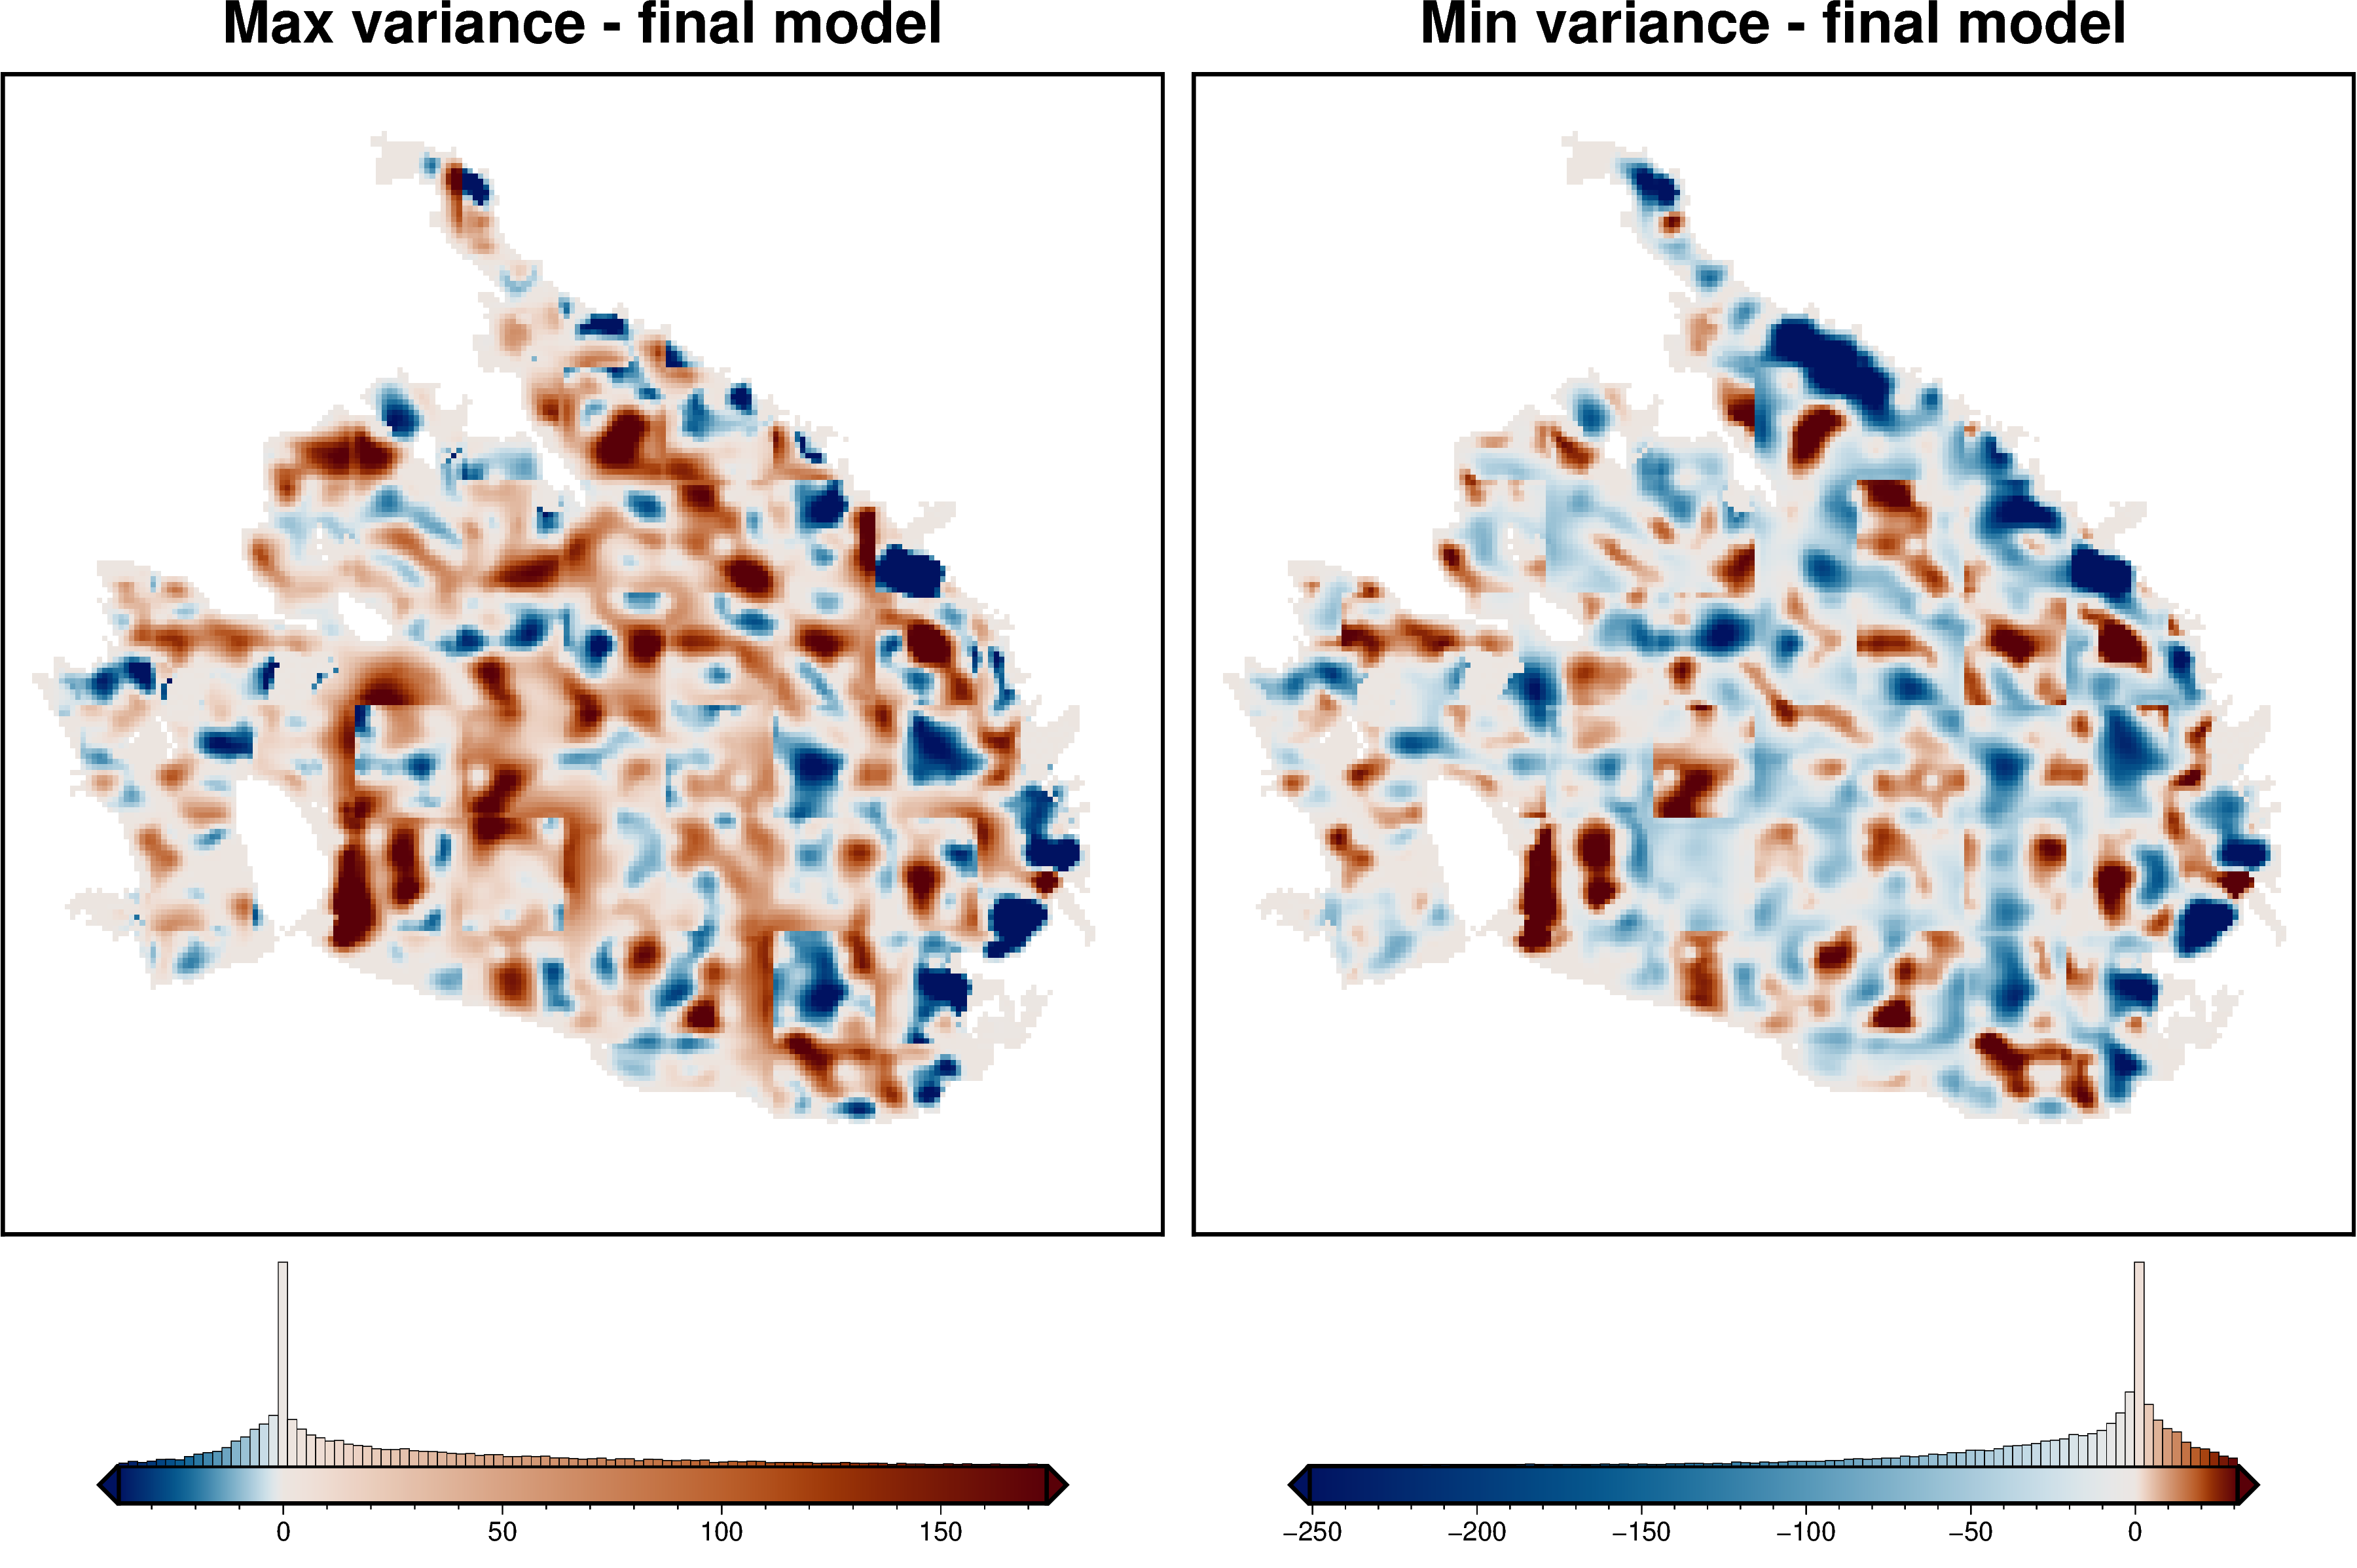

In [8]:
inverted_bathy_mask = utils.mask_from_shp(
    shapefile="../plotting/RIS_outline.shp",
    xr_grid=inverted_bathy,
    masked=True,
    invert=False,
)
max_to_final = merged_max - inverted_bathy_mask
min_to_final = merged_min - inverted_bathy_mask

fig = maps.plot_grd(
    max_to_final,
    title="Max variance - final model",
    cmap="vik+h0",
    robust=True,
    hist=True,
)
fig = maps.plot_grd(
    min_to_final,
    title="Min variance - final model",
    cmap="vik+h0",
    robust=True,
    hist=True,
    fig=fig,
    origin_shift="xshift",
)
fig.show()

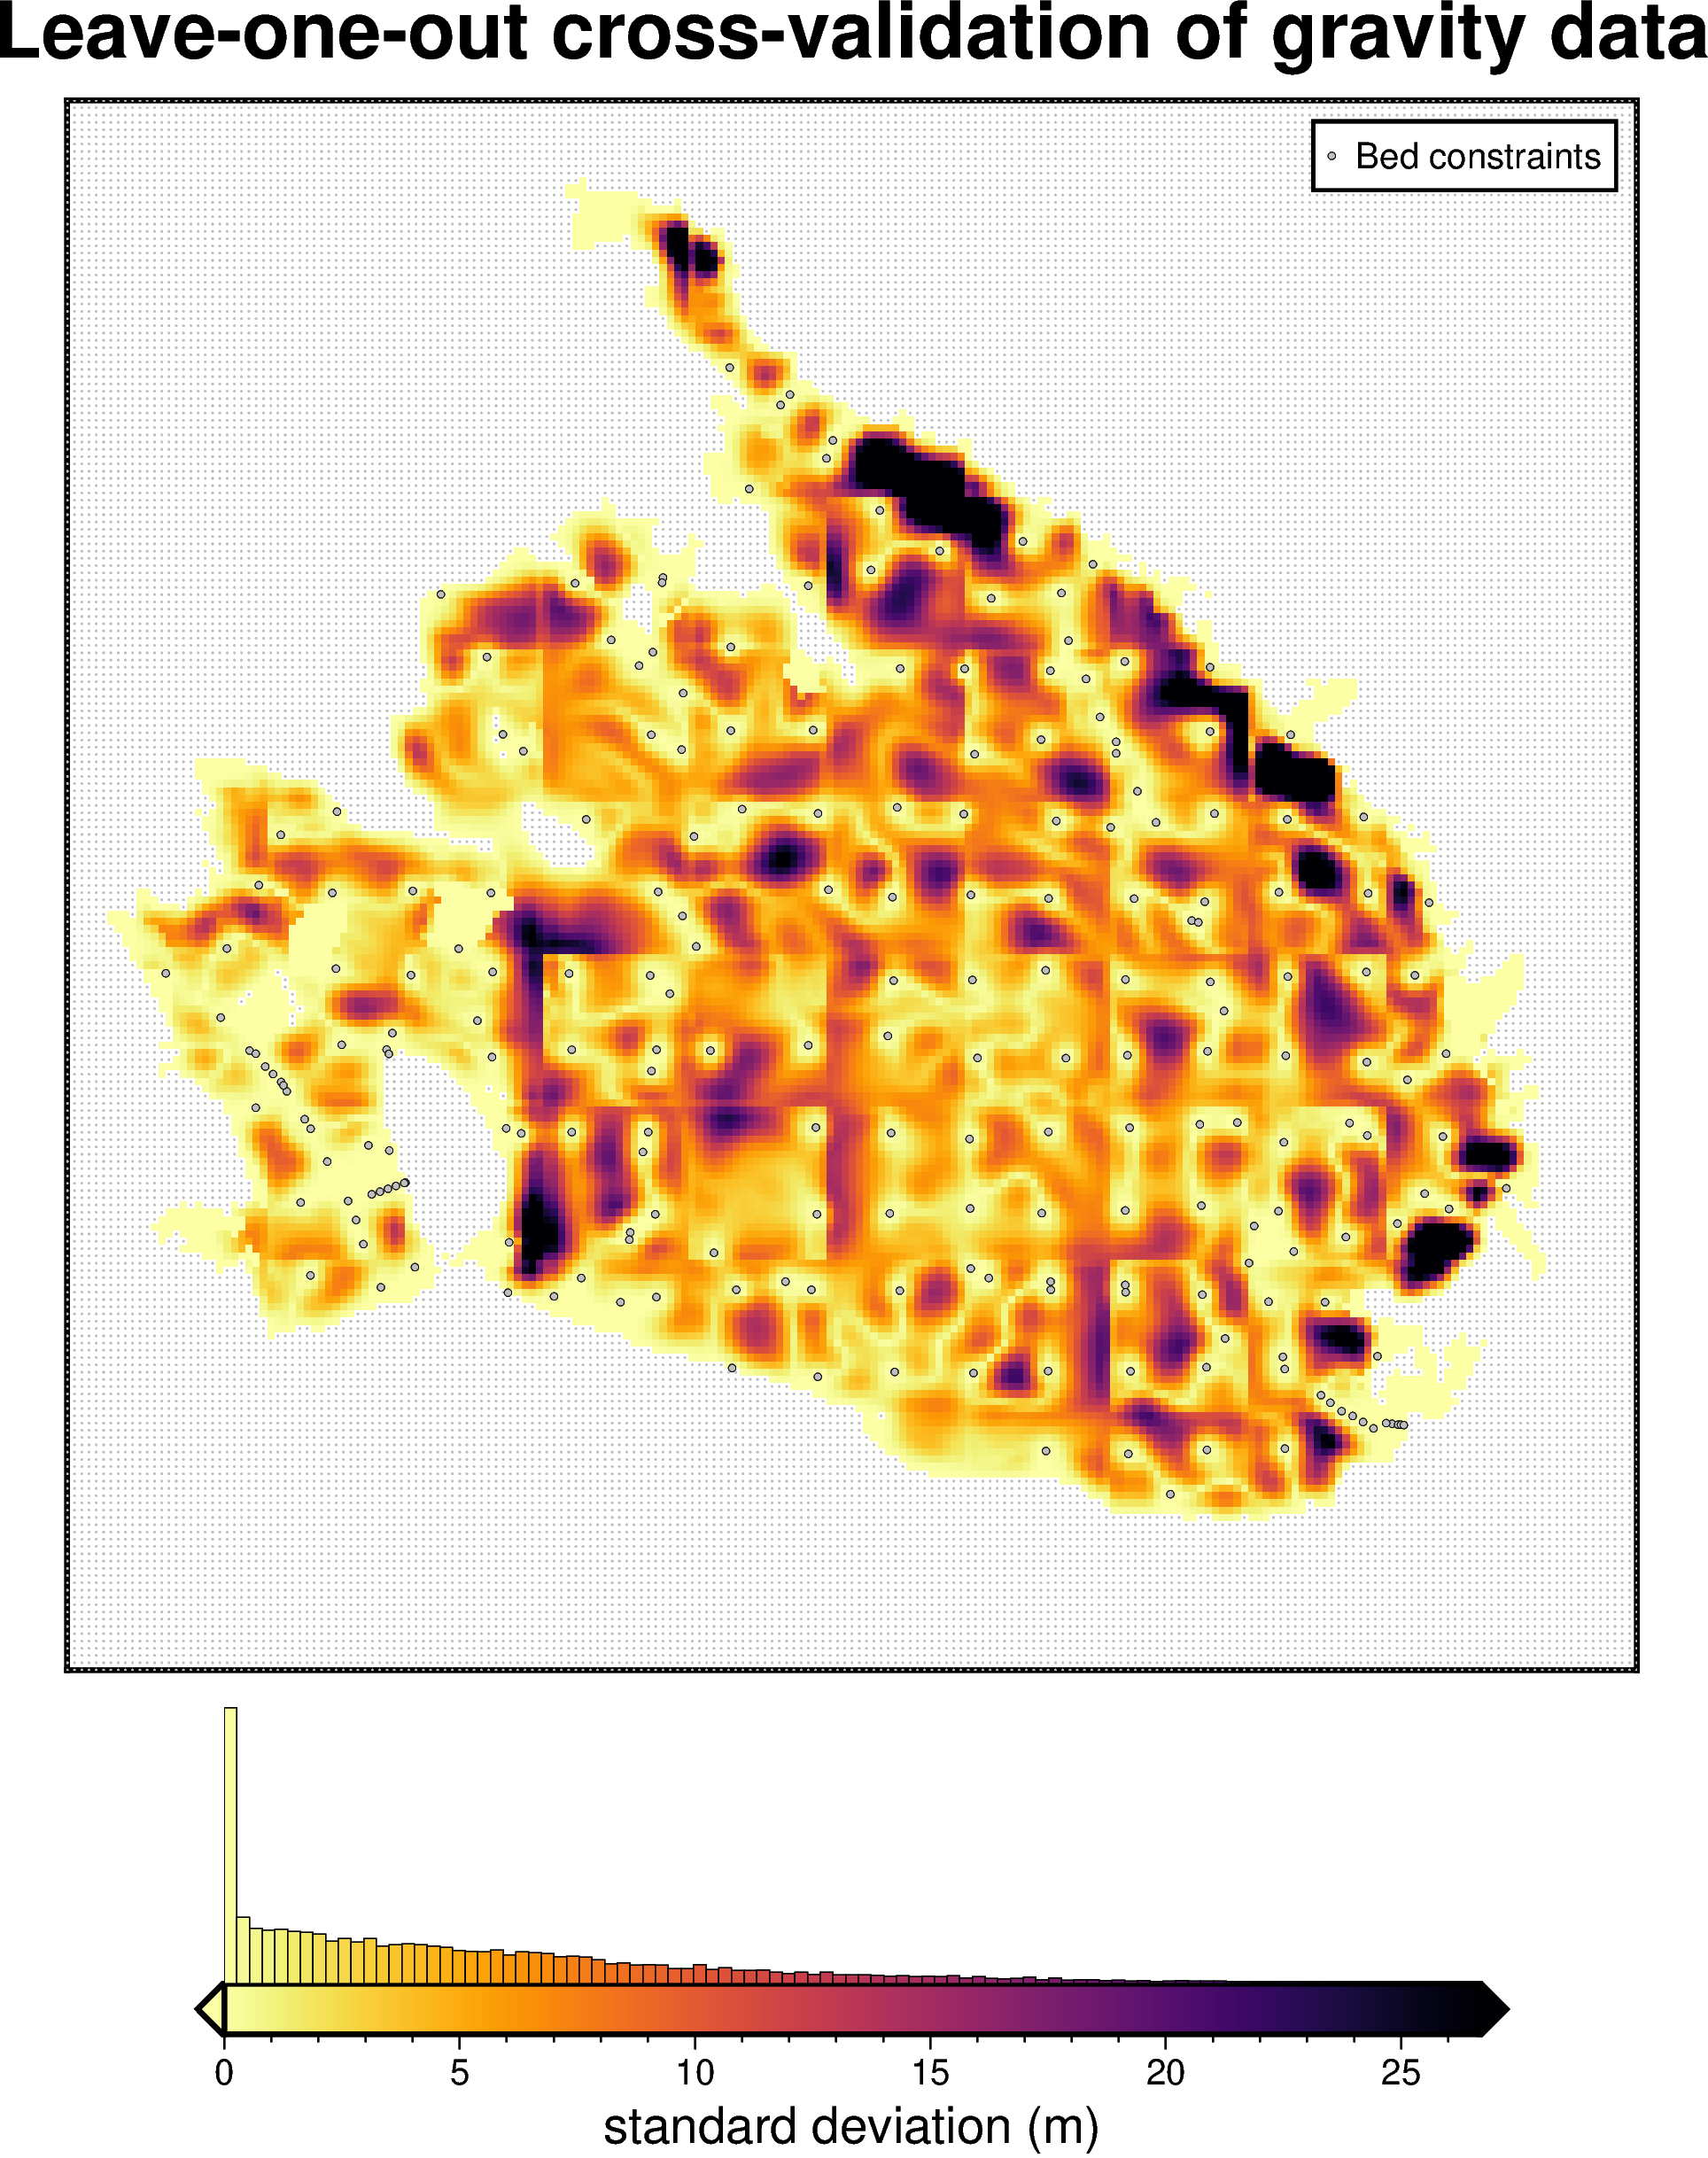

In [9]:
stdev = ds_merged["fold_num"].std("folds").rename("stdev")
stdev = utils.mask_from_shp(
    shapefile="../plotting/RIS_outline.shp", xr_grid=stdev, masked=True, invert=False
)

fig = maps.plot_grd(
    stdev,
    cmap="inferno",
    reverse_cpt=True,
    robust=True,
    hist=True,
    cbar_label="standard deviation (m)",
    title='"Leave-one-out" cross-validation of gravity data',
)

fig.plot(
    x=constraints.easting,
    y=constraints.northing,
    fill="gray",
    style="c.02c",
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    fill="gray",
    pen=".1p,black",
    style="c.07c",
    label="Bed constraints",
)
fig.legend()

fig.show()

In [10]:
constraints

,northing,easting,upward,lat,lon,station_ID,z_geoidal,z_error,measurement_type,inside
24072,-1.460000e+06,-620000.000000,-3613.190674,NaN,NaN,NaN,NaN,NaN,NaN,False
24073,-1.460000e+06,-615000.000000,-3614.358154,NaN,NaN,NaN,NaN,NaN,NaN,False
24074,-1.460000e+06,-610000.000000,-3607.669189,NaN,NaN,NaN,NaN,NaN,NaN,False
24075,-1.460000e+06,-605000.000000,-3614.168213,NaN,NaN,NaN,NaN,NaN,NaN,False
24076,-1.460000e+06,-600000.000000,-3645.910156,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...
104190,-8.164639e+05,-218050.118799,-564.000000,-82.23361,-165.0472,19.0,NaN,NaN,NaN,True
104191,-1.087485e+06,-452466.872984,-714.000000,-79.19028,-157.4094,19.0,NaN,NaN,NaN,True
104192,-1.033177e+06,-214445.845201,-512.000000,-80.31055,-168.2742,19.0,NaN,NaN,NaN,True
104193,-8.266453e+05,-197189.312136,-583.000000,-82.19000,-166.5833,1.0,NaN,NaN,NaN,True


# Other stuff

In [ ]:
# fig = maps.basemap(
#     region=buffer_region,
#     coast=True,
# )

# for x, y in zip(blocks[0], blocks[1]):
#     fig.plot(
#         x = x,
#         y = y,
#         style="c0.3c",
#         fill="red",
#     )

# fig.show()

In [72]:
# train, test = vd.train_test_split(
#     (df_anomalies.easting, df_anomalies.northing),
#     data = df_anomalies.res,
#     # spacing=50e3,
#     shape = (10,10),
# )
# test

In [69]:
# fig = maps.basemap(
#     region=buffer_region,
#     coast=True,
# )
# # for x, y in zip(test[0][0], test[0][1]):
# fig.plot(
#     x = train[0][0],
#     y = train[0][1],
#     style="c0.01c",
#     fill="blue",
# )
# fig.plot(
#     x = test[0][0],
#     y = test[0][1],
#     style="c0.1c",
#     fill="red",
# )

# fig.show()

In [70]:
# df_anomalies.describe()

In [71]:
# df_test_train = inv_utils.split_gravity_test_train(
#     df_anomalies,
#     # spacing = 100e3,
#     shape = (20,2),
#     n_splits = 10,
#     test_size = 1,
#     plot=True,
#     number_to_plot = 2,
# )
# # print(f"Test points in fold 0: {len(df_test_train[df_test_train.fold_0==' test'])}")
# df_test_train